In [1]:
import math
import numpy as np 
import sub_func_ce
from sub_func_ce import abs_dis, find_overlap
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn import mixture
from random import randrange
from IPython.display import clear_output
import os
from matplotlib import cm
import pickle
from msad_ana import msad_ana_qua

from torch.nn.utils import clip_grad_norm_
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter

# %matplotlib widget
%matplotlib inline

def normal_dist(x, mu, std):
    prob_density = (np.pi*std) * np.exp(-0.5*((x-mu)/std)**2)
    return prob_density
    
def draw_3d(ind_raw):
    ind_raw = np.array(ind_raw)
    plt.rcParams["figure.figsize"] = [5, 5]
    # plt.rcParams["figure.autolayout"] = True
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(ind_raw[:,0], ind_raw[:,1], ind_raw[:,2], alpha = 0.5, c = 'r')
    plt.show()

def ele_list_gen(cr_c, mn_c, co_c, ni_c, num_c, mode = 'randchoice'):
    np.random.seed()

    assert abs(cr_c + mn_c + co_c + ni_c - 1) < 0.001, 'Make sure atomic ratio sum to 1'

    while True:
        if mode == 'randchoice':
            len_cr = randrange(int(cr_c*num_c),int(cr_c*num_c)+2)
            len_mn = randrange(int(mn_c*num_c),int(mn_c*num_c)+2)
            len_co = randrange(int(co_c*num_c),int(co_c*num_c)+2)
        elif mode == 'int':
            len_cr = int(cr_c*num_c)
            len_mn = int(mn_c*num_c)
            len_co = int(co_c*num_c)
        
        len_ni = num_c-len_cr-len_mn-len_co
        if abs(len_ni-num_c*ni_c) <= 1:
            break

    ele_list_raw = np.concatenate([np.zeros(len_cr)+2,np.ones(len_mn),0-np.ones(len_co),-1-np.ones(len_ni)],axis=0)
    np.random.shuffle(ele_list_raw)
    
    return ele_list_raw

def swap_step(action, state,):

    a1 = action[0]
    a2 = action[1]

    state[a2], state[a1] = state[a1], state[a2]

    return state

def create_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print("Created Directory : ", directory)
    else:
        print("Directory already existed : ", directory)
    return directory

class CE:
    def __init__(self, ind_1nn, ind_2nn, ind_3nn, ind_4nn, 
                ind_qua1nn, ind_qua1nn2nn,
                ind_trip1nn, ind_trip1nn2nn, ind_trip1nn2nn3nn,
                ind_1nn_pbc, ind_2nn_pbc, ind_3nn_pbc, ind_4nn_pbc, 
                ind_qua1nn_pbc, ind_qua1nn2nn_pbc, 
                ind_trip1nn_pbc, ind_trip1nn2nn_pbc, ind_trip1nn2nn3nn_pbc,
                ind_raw,):

        #* Inner of 32-atom config.
        self.ind_1nn = ind_1nn
        self.ind_2nn = ind_2nn
        self.ind_3nn = ind_3nn
        self.ind_4nn = ind_4nn
        self.ind_qua1nn = ind_qua1nn
        self.ind_qua1nn2nn = ind_qua1nn2nn
        self.ind_trip1nn = ind_trip1nn
        self.ind_trip1nn2nn = ind_trip1nn2nn
        self.ind_trip1nn2nn3nn = ind_trip1nn2nn3nn

        #* Cluster on boundary of primary config.
        self.ind_1nn_pbc = ind_1nn_pbc
        self.ind_2nn_pbc = ind_2nn_pbc
        self.ind_3nn_pbc = ind_3nn_pbc
        self.ind_4nn_pbc = ind_4nn_pbc
        self.ind_qua1nn_pbc = ind_qua1nn_pbc
        self.ind_qua1nn2nn_pbc = ind_qua1nn2nn_pbc
        self.ind_trip1nn_pbc = ind_trip1nn_pbc
        self.ind_trip1nn2nn_pbc = ind_trip1nn2nn_pbc
        self.ind_trip1nn2nn3nn_pbc = ind_trip1nn2nn3nn_pbc

        self.ind_raw = ind_raw
        # self.ind_pbc = ind_pbc

        self.sym_oplist = np.array([2, 1, 1, 0, 6, 0, 4, 12, 24])
        self.sym_optri = np.array([6, 3, 1])
        self.sym_opqua = np.array([0, 0, 1, 0, 0, 0, 2, 0, 4])

    #*Normalizaiton by the symmetry operation for each cluster
    def sym_operator(self, cluster, mode='None'):
        if mode == 'None':
            mode_cluster = len(cluster)
            uni, count_uni = np.unique(cluster, return_counts=True)
            len_uni = len(uni)
            count_uni = np.sort(count_uni)
            mode_sym = mode_cluster - len(uni)
            sym_op = self.sym_oplist[mode_sym+mode_cluster-2]

        if mode == 'tri1nn':
            mode_cluster = len(cluster)
            uni, count_uni = np.unique(cluster, return_counts=True)
            len_uni = len(uni)
            mode_sym = mode_cluster - len(uni)
            sym_op = self.sym_optri[mode_sym]
        
        if mode == 'qua1nn':
            uni, count_uni = np.unique(cluster, return_counts=True)
            len_uni = len(uni)
            count_uni = np.sort(count_uni)
            len_count = len(count_uni)
            c_ind = len_uni+len_count+count_uni[-1]-count_uni[0]
            sym_op = self.sym_oplist[c_ind]

        if mode == 'qua1nn2nn':
            uni, count_uni = np.unique(cluster, return_counts=True)
            len_uni = len(uni)
            count_uni = np.sort(count_uni)
            len_count = len(count_uni)
            c_ind = len_uni+len_count+count_uni[-1]-count_uni[0]
            single_list = np.array([2, 6, 8])
            if c_ind in single_list:
                sym_op = self.sym_opqua[c_ind]
            else:
                if c_ind == 4:
                    if len(np.unique(cluster[:2])) == 2:
                        sym_op = 4
                    else:
                        sym_op = 1

                elif c_ind == 7:
                    if len(np.unique(cluster[:2])) == 2 and len(np.unique(cluster[2:4])) == 2:
                        sym_op = 4
                    else:
                        sym_op = 2

        return sym_op

    def phi1(self, x):
        return 2/math.sqrt(10)*x

    def phi2(self, x):
        return -5/3 + 2/3*(x**2)

    def phi3(self, x):
        return -17/30*math.sqrt(10)*x + math.sqrt(10)/6*(x**3)
    
    #*Return the correlation function for each cluster
    def cpr(self, val_list):
        p1l = self.phi1(val_list).reshape(-1, 1)
        p2l = self.phi2(val_list).reshape(-1, 1)
        p3l = self.phi3(val_list).reshape(-1, 1)
        pl = np.concatenate([p1l, p2l, p3l], 1).T
        c_len = len(val_list)
        atom = 1
        for i in range(c_len):
            atom_1 = pl[:, i]
            atom = np.outer(atom_1, atom)

        return atom.flatten()

    def cluster_extra(self, config):
        '''
        Config in PBC must be in N*27 form.
        '''
        cpr_1nn = 0
        for i in self.ind_1nn:
            a1, a2 = config[i[0]], config[i[1]]
            cluster = np.array([a1, a2])
            cpr_1nn += self.cpr(cluster)/self.sym_operator(cluster)

        for i in self.ind_1nn_pbc:
            a1, a2 = config[i[0]], config[i[1]]
            cluster = np.array([a1, a2])
            cpr_1nn += self.cpr(cluster)/self.sym_operator(cluster)       
        
        cpr_1nn /= (len(self.ind_1nn)+len(self.ind_1nn_pbc))

        cpr_2nn = 0
        for i in self.ind_2nn:
            a1, a2 = config[i[0]], config[i[1]]
            cluster = np.array([a1, a2])
            cpr_2nn += self.cpr(cluster)/self.sym_operator(cluster)

        for i in self.ind_2nn_pbc:
            a1, a2 = config[i[0]], config[i[1]]
            cluster = np.array([a1, a2])
            cpr_2nn += self.cpr(cluster)/self.sym_operator(cluster)

        cpr_2nn /= (len(self.ind_2nn)+len(self.ind_2nn_pbc))
        
        cpr_3nn = 0
        for i in self.ind_3nn:
            a1, a2 = config[i[0]], config[i[1]]
            cluster = np.array([a1, a2])
            cpr_3nn += self.cpr(cluster)/self.sym_operator(cluster)

        for i in self.ind_3nn_pbc:
            a1, a2 = config[i[0]], config[i[1]]
            cluster = np.array([a1, a2])
            cpr_3nn += self.cpr(cluster)/self.sym_operator(cluster)

        cpr_3nn /= (len(self.ind_3nn)+len(self.ind_3nn_pbc))

        cpr_4nn = 0
        for i in self.ind_4nn:
            a1, a2 = config[i[0]], config[i[1]]
            cluster = np.array([a1, a2])
            cpr_4nn += self.cpr(cluster)/self.sym_operator(cluster)

        for i in self.ind_4nn_pbc:
            a1, a2 = config[i[0]], config[i[1]]
            cluster = np.array([a1, a2])
            cpr_4nn += self.cpr(cluster)/self.sym_operator(cluster)

        cpr_4nn /= (len(self.ind_4nn)+len(self.ind_4nn_pbc))
            
        cpr_tri1nn = 0
        for i in self.ind_trip1nn:
            a1, a2, a3 = config[i[0]], config[i[1]], config[i[2]]
            cluster = np.array([a1, a2, a3])
            cpr_tri1nn += self.cpr(cluster)/self.sym_operator(cluster, mode='tri1nn')

        for i in self.ind_trip1nn_pbc:
            a1, a2, a3 = config[i[0]], config[i[1]], config[i[2]]
            cluster = np.array([a1, a2, a3])
            cpr_tri1nn += self.cpr(cluster)/self.sym_operator(cluster, mode='tri1nn')

        cpr_tri1nn /= (len(self.ind_trip1nn)+len(self.ind_trip1nn_pbc))

        cpr_tri1nn2nn = 0
        for i in self.ind_trip1nn2nn:
            a1, a2, a3 = config[i[0]], config[i[1]], config[i[2]]
            cluster = np.array([a1, a2, a3])
            #* Symmetry operation will be doen only in AAB form
            if (a1 == a2 and a1 != a3) or (a1 == a3 and a1 != a2):
                cpr_tri1nn2nn += self.cpr(cluster)/2
            else:
                cpr_tri1nn2nn += self.cpr(cluster)

        for i in self.ind_trip1nn2nn_pbc:
            a1, a2, a3 = config[i[0]], config[i[1]], config[i[2]]
            cluster = np.array([a1, a2, a3])
            #* Symmetry operation will be doen only in AAB form
            if (a1 == a2 and a1 != a3) or (a1 == a3 and a1 != a2):
                cpr_tri1nn2nn += self.cpr(cluster)/2
            else:
                cpr_tri1nn2nn += self.cpr(cluster)

        cpr_tri1nn2nn /= (len(self.ind_trip1nn2nn)+len(self.ind_trip1nn2nn_pbc))

        cpr_tri1nn2nn3nn = 0
        for i in self.ind_trip1nn2nn3nn:
            a1, a2, a3 = config[i[0]], config[i[1]], config[i[2]]
            cluster = np.array([a1, a2, a3])
            cpr_tri1nn2nn3nn += self.cpr(cluster)

        for i in self.ind_trip1nn2nn3nn_pbc:
            a1, a2, a3 = config[i[0]], config[i[1]], config[i[2]]
            cluster = np.array([a1, a2, a3])
            cpr_tri1nn2nn3nn += self.cpr(cluster)

        cpr_tri1nn2nn3nn /= (len(self.ind_trip1nn2nn3nn)+len(self.ind_trip1nn2nn3nn_pbc))

        #!Consider the operation in qua later
        cpr_qua1nn = 0
        for i in self.ind_qua1nn:
            a1, a2, a3, a4 = config[i[0]], config[i[1]], config[i[2]], config[i[3]]
            cluster = np.array([a1, a2, a3, a4])
            cpr_qua1nn += self.cpr(cluster)/self.sym_operator(cluster, mode='qua1nn')

        for i in self.ind_qua1nn_pbc:
            a1, a2, a3, a4 = config[i[0]], config[i[1]], config[i[2]], config[i[3]]
            cluster = np.array([a1, a2, a3, a4])
            cpr_qua1nn += self.cpr(cluster)/self.sym_operator(cluster, mode='qua1nn')

        cpr_qua1nn /= (len(self.ind_qua1nn) + len(self.ind_qua1nn_pbc))

        cpr_qua1nn2nn = 0
        for i in self.ind_qua1nn2nn:
            a1, a2, a3, a4 = config[i[0]], config[i[1]], config[i[2]], config[i[3]]
            cluster = np.array([a1, a2, a3, a4])
            cpr_qua1nn2nn += self.cpr(cluster)/self.sym_operator(cluster, mode='qua1nn2nn')

        for i in self.ind_qua1nn2nn_pbc:
            a1, a2, a3, a4 = config[i[0]], config[i[1]], config[i[2]], config[i[3]]
            cluster = np.array([a1, a2, a3, a4])
            cpr_qua1nn2nn += self.cpr(cluster)/self.sym_operator(cluster, mode='qua1nn2nn')

        cpr_qua1nn2nn /= (len(self.ind_qua1nn2nn)+len(self.ind_qua1nn2nn_pbc))

        return np.concatenate([
            cpr_1nn, cpr_2nn, cpr_3nn, cpr_4nn,
            cpr_tri1nn, cpr_tri1nn2nn, cpr_tri1nn2nn3nn,
            cpr_qua1nn, cpr_qua1nn2nn,
        ], 0)

    def config_extra(self, num_cell, ind_cr, ind_mn, ind_co, ind_ni):
        ele_list = np.zeros(num_cell)
        overlap_cr = find_overlap(self.ind_raw, ind_cr)
        overlap_mn = find_overlap(self.ind_raw, ind_mn)
        overlap_co = find_overlap(self.ind_raw, ind_co)
        overlap_ni = find_overlap(self.ind_raw, ind_ni)

        ele_list[np.where(overlap_cr)[0]] = 2
        ele_list[np.where(overlap_mn)[0]] = 1
        ele_list[np.where(overlap_co)[0]] = -1
        ele_list[np.where(overlap_ni)[0]] = -2

        #* Embedding form in PBC
        ele_list = np.tile(ele_list, 27)
        cpr_list = self.cluster_extra(ele_list)

        return cpr_list

    def read(self, incar_dir):
        with open(incar_dir) as f:
            input_strip = [s.strip() for s in f.readlines()]
        return input_strip

[ 151.82222222 -120.02600541   75.91111111   94.88888889  -60.01300271
   37.95555556] [ 73.95555556 -58.46700029  36.97777778  46.22222222 -29.23350015
  18.48888889] [ 219.02222222 -173.1522701   109.51111111  136.88888889  -86.57613505
   54.75555556] [106.66666667 -84.32740427  53.33333333  66.66666667 -42.16370214
  26.66666667] [ 205.51111111 -162.4707989   102.75555556  128.44444444  -81.23539945
   51.37777778] [ 51.2        -40.47715405  25.6         32.         -20.23857703
  12.8       ]


In [5]:

ind_raw

array([[0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.5 ],
       [0.  , 0.25, 0.25],
       [0.  , 0.25, 0.75],
       [0.  , 0.5 , 0.  ],
       [0.  , 0.5 , 0.5 ],
       [0.  , 0.75, 0.25],
       [0.  , 0.75, 0.75],
       [0.25, 0.  , 0.25],
       [0.25, 0.  , 0.75],
       [0.25, 0.25, 0.  ],
       [0.25, 0.25, 0.5 ],
       [0.25, 0.5 , 0.25],
       [0.25, 0.5 , 0.75],
       [0.25, 0.75, 0.  ],
       [0.25, 0.75, 0.5 ],
       [0.5 , 0.  , 0.  ],
       [0.5 , 0.  , 0.5 ],
       [0.5 , 0.25, 0.25],
       [0.5 , 0.25, 0.75],
       [0.5 , 0.5 , 0.  ],
       [0.5 , 0.5 , 0.5 ],
       [0.5 , 0.75, 0.25],
       [0.5 , 0.75, 0.75],
       [0.75, 0.  , 0.25],
       [0.75, 0.  , 0.75],
       [0.75, 0.25, 0.  ],
       [0.75, 0.25, 0.5 ],
       [0.75, 0.5 , 0.25],
       [0.75, 0.5 , 0.75],
       [0.75, 0.75, 0.  ],
       [0.75, 0.75, 0.5 ]])

In [11]:

cont_dir=f'/media/wz/7AD631A4D6316195/Projects/MSAD/outputs_32_crmnconi/Struc/CONTCAR1'
pos_dir=f'/media/wz/7AD631A4D6316195/Projects/MSAD/outputs_32_crmnconi/Struc/POSCAR1'

lattice_param = 3.512
cell_num = 2
atom_num = 32
ele_list = np.zeros((atom_num, 4))
param = msad_ana_qua(cont_dir, pos_dir, lattice_param, cell_num)
ind_raw = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_raw32.npy')
cr_coord = param['Cr_coord']/lattice_param/cell_num
mn_coord = param['Mn_coord']/lattice_param/cell_num
co_coord = param['Co_coord']/lattice_param/cell_num
ni_coord = param['Ni_coord']/lattice_param/cell_num
embed_list = np.concatenate([
    np.ones(len(cr_coord))*2,
    np.ones(len(mn_coord)),
    -np.ones(len(co_coord)),
    -np.ones(len(ni_coord))*2
]).reshape(-1,1)
res_coord = param['Residual']*100 #* Convert to pm

ind_cr = np.where(find_overlap(ind_raw, cr_coord))[0]
ind_mn = np.where(find_overlap(ind_raw, mn_coord))[0]
ind_co = np.where(find_overlap(ind_raw, co_coord))[0]
ind_ni = np.where(find_overlap(ind_raw, ni_coord))[0]
ind_all = np.concatenate([ind_cr, ind_mn, ind_co, ind_ni]).reshape(-1,1)

ind_embed = np.concatenate([embed_list, ind_all], axis=1)

for i in range(atom_num):
    part_embed = ind_embed[i]
    #* Index in element list
    ind = int(part_embed[1])
    specie = part_embed[0]
    
    ele_list[ind][0] = specie
    ele_list[ind][1:] = res_coord[i]

ele_list

array([[-2.        , -0.7394139 ,  0.34944312, -1.01688043],
       [ 1.        , -1.28076414,  4.14163702, -4.3215453 ],
       [ 2.        ,  1.75067446,  2.81332293,  0.33553692],
       [ 2.        ,  5.23398028, -4.01093797, -2.73126994],
       [-2.        ,  2.70426133, -1.27655135, -0.47531938],
       [-2.        , -0.74575957, -0.13372986,  1.27558891],
       [ 2.        , -0.59251752, -3.10965998,  2.31174346],
       [-1.        , -0.18856985, -1.36491054, -0.31069899],
       [-2.        , -1.32316406,  0.47653675,  1.09174853],
       [-1.        , -1.59722968, -1.24483685, -2.37363945],
       [ 1.        ,  0.35036532,  0.84593346,  3.21223543],
       [-1.        , -0.93026763, -0.39496019,  1.26856184],
       [ 1.        ,  0.99976563,  1.48337735,  0.65133076],
       [-2.        , -0.94097137,  0.03818798,  1.34199059],
       [-2.        , -2.45860845,  0.22281053, -0.65670022],
       [-1.        ,  3.27207295,  0.27224108,  3.90054122],
       [-2.        ,  2.

In [8]:
np.zeros((4, 32))

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

31.09934625


(array([ 2.,  2.,  0.,  0.,  2.,  4.,  4.,  5.,  6.,  9.,  4.,  6.,  7.,
        10.,  6.,  5., 10., 10., 13., 14., 13., 11.,  7., 19., 18., 18.,
        22., 12.,  8., 19., 11., 13., 12.,  6.,  9.,  9.,  5., 10.,  5.,
         6.,  5.,  3.,  3.,  3.,  4.,  3.,  1.,  5.,  3.,  3.,  3.,  0.,
         2.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  2.,  1.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 3.50048568,  3.57467322,  3.64886076,  3.72304831,  3.79723585,
         3.87142339,  3.94561093,  4.01979848,  4.09398602,  4.16817356,
         4.2423611 ,  4.31654864,  4.39073619,  4.46492373,  4.53911127,
         4.61329881,  4.68748636,  4.7616739 ,  4.83586144,  4.91004898,
         4.98423652,  5.05842407,  5.13261161,  5.20679915,  5.28098669,
         5.35517424,  5.42936178,  5.50354932,  5.57773686,  5.651924

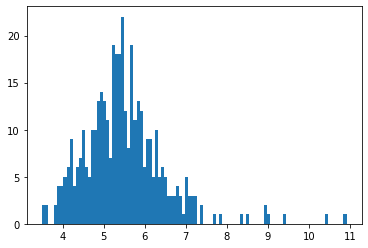

In [2]:
msad_list = []
for i in range(1, 401):
    cont_dir=f'/media/wz/7AD631A4D6316195/Projects/MSAD/outputs_32_crmnconi/Struc/CONTCAR{i}'
    pos_dir=f'/media/wz/7AD631A4D6316195/Projects/MSAD/outputs_32_crmnconi/Struc/POSCAR{i}'

    msad_list.append(msad_ana_qua(cont_dir, pos_dir, 3.512, 2)['MSAD'])

print(np.mean(msad_list))
msad_list = np.sqrt(np.array(msad_list))
plt.hist(msad_list, bins=100)

#### Generating the datasets

In [3]:
#* Deducing step
ind_1nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_1nn.npy')
ind_2nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_2nn.npy')
ind_3nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_3nn.npy')
ind_4nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_4nn.npy')
ind_qua1nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_qua1nn.npy')
ind_qua1nn2nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_qua1nn2nn.npy')
ind_trip1nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_trip1nn.npy')
ind_trip1nn2nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_trip1nn2nn.npy')
ind_trip1nn2nn3nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_trip1nn2nn3nn.npy')

ind_1nn_pbc = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_1nn_pbc.npy')
ind_2nn_pbc = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_2nn_pbc.npy')
ind_3nn_pbc = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_3nn_pbc.npy')
ind_4nn_pbc = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_4nn_pbc.npy')
ind_qua1nn_pbc = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_qua1nn_pbc.npy')
ind_qua1nn2nn_pbc = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_qua1nn2nn_pbc.npy')
ind_trip1nn_pbc = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_trip1nn_pbc.npy')
ind_trip1nn2nn_pbc = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_trip1nn2nn_pbc.npy')
ind_trip1nn2nn3nn_pbc = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_trip1nn2nn3nn_pbc.npy')

ind_raw = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_raw32.npy')

weight_list, energy = [], []
ce_ = CE(ind_1nn, ind_2nn, ind_3nn, ind_4nn, 
        ind_qua1nn, ind_qua1nn2nn, 
        ind_trip1nn, ind_trip1nn2nn, ind_trip1nn2nn3nn,
        ind_1nn_pbc, ind_2nn_pbc, ind_3nn_pbc, ind_4nn_pbc, 
        ind_qua1nn_pbc, ind_qua1nn2nn_pbc, 
        ind_trip1nn_pbc, ind_trip1nn2nn_pbc, ind_trip1nn2nn3nn_pbc,
        ind_raw)
atom_num = 32

for i in range(1, 401):
    ind_cr = np.load(f'/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/252525/Cr25Mn25Co25Ni2532_try{i}/Cr25Mn25Co25Ni25_cr_chosen.npy')
    ind_mn = np.load(f'/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/252525/Cr25Mn25Co25Ni2532_try{i}/Cr25Mn25Co25Ni25_mn_chosen.npy')
    ind_co = np.load(f'/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/252525/Cr25Mn25Co25Ni2532_try{i}/Cr25Mn25Co25Ni25_co_chosen.npy')
    ind_ni = np.load(f'/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/252525/Cr25Mn25Co25Ni2532_try{i}/Cr25Mn25Co25Ni25_ni_chosen.npy')

    #* Free energy
    osz_dir = f'/media/wz/7AD631A4D6316195/Projects/MSAD/outputs_32_crmnconi/Cr25Mn25Co25Ni25_3.512_try{i}/OSZICAR'
    oszicar = ce_.read(osz_dir)[-1]
    # e_ground = float(''.join(oszicar).split()[-6]) 

    #* Extract cluster info.
    ce_feature = ce_.config_extra(atom_num, ind_cr, ind_mn, ind_co, ind_ni)

    weight_list.append(ce_feature)
    # energy.append(e_ground)

weight_list = np.array(weight_list) #* Per atom

#* Normalization
# energy_min, energy_max = np.min(energy), np.max(energy)
# energy_std = np.std(energy)
# energy_mean = np.mean(energy)
# energy = (energy - energy_mean) / energy_std

# weight_std = np.std(weight_list, axis=0)
# weight_mean = np.mean(weight_list, axis=0)
# weight_list = (weight_list - weight_mean) / weight_std

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
weight_list = torch.from_numpy(weight_list.astype(np.float32)).clone()
# energy = torch.from_numpy(energy.astype(np.float32)).clone()
weight_list = weight_list.to(device)
# energy = energy.reshape(-1,1).to(device)

##### Visualization of energy distribution

{'gamma': {'a': 13.974722405113548, 'loc': -8.068869730968498, 'scale': 0.023117726123996103}}


,sumsquare_error,aic,bic,kl_div
gamma,1007.286244,311.712893,388.110119,inf


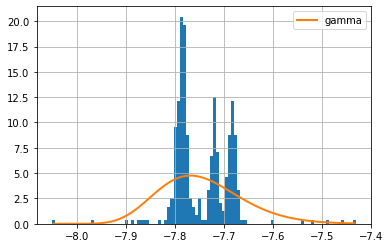

In [20]:
%matplotlib inline
from fitter import Fitter
#* Check the distribution of energy
energy_hist = energy.clone().cpu().numpy().flatten()
valy_pair = np.array([round(i, 3) for i in energy_hist])
f_pair = Fitter(valy_pair, distributions = ['gamma'], timeout = 1500)
f_pair.fit()

print(f_pair.get_best())
f_pair.summary()

##### A GMM implementation for determining the **Energy cluster**

From a statistical mechanics' perspective, each independent distribution of $F$ can be regarded as an energy basin representing a distinct ***configurational state***   $\Omega_a$.

(array([ 2.,  2.,  2.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  5.,  2.,  3.,
         5., 10.,  8., 13.,  7., 11.,  5.,  3.,  1.,  2.,  1.,  0.,  0.,
         2.,  2.,  4.,  6.,  3., 10.,  9.,  7., 11., 13.,  7.,  5.,  5.,
         2.,  5.,  1.,  0.,  1.,  0.,  1.]),
 array([-7.753458 , -7.7513847, -7.7493114, -7.747238 , -7.745165 ,
        -7.743091 , -7.741018 , -7.7389445, -7.7368712, -7.734798 ,
        -7.7327247, -7.7306514, -7.728578 , -7.726505 , -7.724431 ,
        -7.7223577, -7.7202845, -7.718211 , -7.716138 , -7.7140646,
        -7.7119913, -7.709918 , -7.7078447, -7.7057714, -7.7036977,
        -7.7016244, -7.699551 , -7.697478 , -7.6954045, -7.6933312,
        -7.691258 , -7.6891847, -7.6871114, -7.6850376, -7.6829643,
        -7.680891 , -7.6788177, -7.6767445, -7.674671 , -7.672598 ,
        -7.6705246, -7.6684513, -7.6663775, -7.6643043, -7.662231 ,
        -7.6601577, -7.6580844], dtype=float32),
 <BarContainer object of 46 artists>)

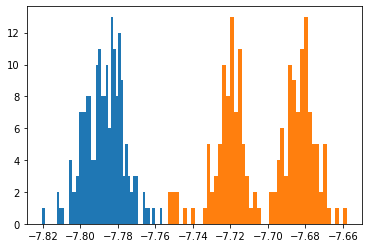

In [21]:
vbgmm = mixture.BayesianGaussianMixture(n_components=3, n_init=4, random_state=0,
    max_iter=1000,)
energy_gmm = energy_hist.reshape(-1,1)
vbgmm.fit(energy_gmm)

labels = vbgmm.predict(energy_gmm)
e_gmm1 = energy_hist[np.where(labels==0)[0]]
e_gmm2 = energy_hist[np.where(labels==1)[0]]
e_gmm3 = energy_hist[np.where(labels==2)[0]]
# e_gmm4 = energy_hist[np.where(labels==3)[0]]

len_all = len(labels)
plt.hist(e_gmm1, bins=int(len(e_gmm1)/len_all*100))
plt.hist(e_gmm2, bins=int(len(e_gmm2)/len_all*100))
# plt.hist(e_gmm3, bins=int(len(e_gmm3)/len_all*100))
# plt.hist(e_gmm4, bins=int(len_all/len(e_gmm4)*100))

In [10]:
mu = np.load('/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools/CE_MC/runs/energy_mu.npy')
std = np.load('/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools/CE_MC/runs/energy_std.npy')
mu, std

(array([-7.78690279, -7.72149139, -7.68259521]),
 array([1.50798284e-04, 1.43727679e-04, 7.41424368e-05]))

Choose ind 1 & 2

(array([2., 0., 2., 0., 0., 3., 1., 2., 3., 1., 2., 1., 0., 5., 6., 2., 4.,
        2., 4., 3., 3., 5., 3., 5., 5., 3., 4., 3., 3., 1., 2., 4., 0., 1.,
        0., 1., 2., 2., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        1.]),
 array([-7.698757 , -7.697975 , -7.6971927, -7.6964107, -7.6956286,
        -7.694846 , -7.694064 , -7.693282 , -7.6924996, -7.6917176,
        -7.6909356, -7.690153 , -7.689371 , -7.688589 , -7.6878066,
        -7.6870246, -7.6862426, -7.68546  , -7.684678 , -7.683896 ,
        -7.6831136, -7.6823316, -7.6815495, -7.680767 , -7.679985 ,
        -7.679203 , -7.678421 , -7.6776385, -7.6768565, -7.6760745,
        -7.675292 , -7.67451  , -7.673728 , -7.6729455, -7.6721635,
        -7.6713815, -7.670599 , -7.669817 , -7.669035 , -7.6682525,
        -7.6674705, -7.6666884, -7.665906 , -7.665124 , -7.664342 ,
        -7.6635594, -7.6627774, -7.6619954, -7.661213 , -7.660431 ,
        -7.659649 , -7.6588664, -7.6580844], dtype=float32),
 <BarContainer ob

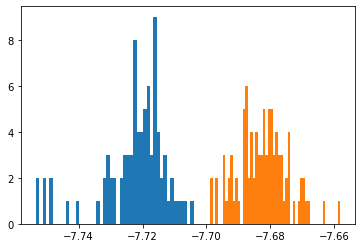

In [22]:
vbgmm = mixture.BayesianGaussianMixture(n_components=2, n_init=4, 
    max_iter=1000, random_state=0,) 
e_gmm2_ = e_gmm2.reshape(-1,1)
vbgmm.fit(e_gmm2_)

labels = vbgmm.predict(e_gmm2_)
e_gmm2_1 = e_gmm2[np.where(labels==0)[0]]
e_gmm2_2 = e_gmm2[np.where(labels==1)[0]]

len_all = len(e_gmm2)
plt.hist(e_gmm2_1, bins=int(len(e_gmm2_1)/len_all*100))
plt.hist(e_gmm2_2, bins=int(len(e_gmm2_2)/len_all*100))

In [22]:
mu_list = np.array([mu1, mu2, mu3])
std_list = np.array([std1, std2, std3])
pth='/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools/CE_MC/runs'
np.save(pth+'/energy_mu', mu_list)
np.save(pth+'/energy_std', std_list)

##### Use dist.'s params for predicting energy labels of input config.

In [23]:
energy_label = np.zeros(len(energy_hist))

for i in range(len(energy_hist)):
    prob_ = normal_dist(energy_hist[i], mu_list, np.sqrt(std_list))
    if np.max(prob_) < 1e-15:
        energy_label[i] = 3 #* Treat such prob. as abnormal
    else:
        energy_label[i] = np.argmax(prob_)

ind_e1 = np.where(energy_label==0)[0]
ind_e2 = np.where(energy_label==1)[0]
ind_e3 = np.where(energy_label==2)[0]

##### A logistic regression analysis for predicting the **energy label** of input configs.

Detailed prediction is taken by tree search.

In [31]:
weight_e_ = weight_list.clone().cpu().numpy()
weight_e1 = weight_e_[ind_e1]
weight_e2 = weight_e_[ind_e2]
weight_e3 = weight_e_[ind_e3]
len_data = len(weight_e_)

weight_e_ = np.concatenate([weight_e1, weight_e2, weight_e3], 0)
#* Seperate 1 & 2+3
label_e_12 = np.concatenate([np.zeros(len(ind_e1)), np.ones(len(ind_e2)+len(ind_e3)),], 0)

elabel_train, elabel_test, eweight_train, eweight_test = train_test_split(
    label_e_12, weight_e_, test_size=0.1)

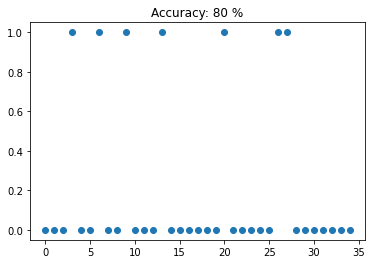

In [33]:
class_weight_12 = {0:len(ind_e1)/len_data, 1:len(ind_e2)/len_data+len(ind_e3)/len_data}

logr_12 = LogisticRegression(C=2000, max_iter=10000, class_weight=class_weight_12,
    multi_class='ovr').fit(eweight_train, elabel_train)
label_test_pre = logr_12.predict(eweight_test)

res_label = np.abs(elabel_test-label_test_pre)
len_true = len(np.where(res_label==0)[0])

plt.scatter(np.arange(len(elabel_test)), np.abs(elabel_test-label_test_pre))
plt.title(f'Accuracy: {int(len_true/len(elabel_test)*100)} %')

plt.show()

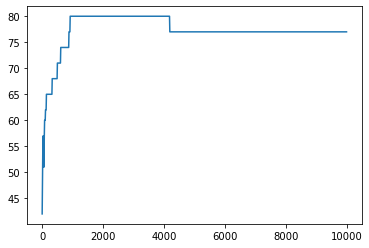

In [32]:
c_list = np.linspace(1e-2, 1e4, 1000)
acc_list = []
for c in c_list:
    logr_12 = LogisticRegression(C=c, max_iter=10000, class_weight=class_weight_12,
        multi_class='ovr').fit(eweight_train, elabel_train)
    label_test_pre = logr_12.predict(eweight_test)

    res_label = np.abs(elabel_test-label_test_pre)
    len_true = len(np.where(res_label==0)[0])
    acc = int(len_true/len(elabel_test)*100)
    acc_list.append(acc)

plt.plot(c_list, acc_list)

In [34]:

#* Seperate 2 & 3
weight_e_23 = np.concatenate([weight_e2, weight_e3], 0)
label_e_23 = np.concatenate([np.zeros(len(ind_e2)), np.ones(len(ind_e3)),], 0)

elabel_train, elabel_test, eweight_train, eweight_test = train_test_split(
    label_e_23, weight_e_23, test_size=0.1)

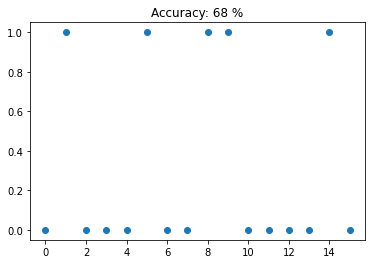

In [37]:
class_weight_23 = {0:len(ind_e2)/len_data, 1:len(ind_e3)/len_data}

logr_23 = LogisticRegression(C=300, max_iter=10000, class_weight=class_weight_23,
    multi_class='ovr').fit(eweight_train, elabel_train)
label_test_pre = logr_23.predict(eweight_test)

res_label = np.abs(elabel_test-label_test_pre)
len_true = len(np.where(res_label==0)[0])

plt.scatter(np.arange(len(elabel_test)), np.abs(elabel_test-label_test_pre))
plt.title(f'Accuracy: {int(len_true/len(elabel_test)*100)} %')

plt.show()

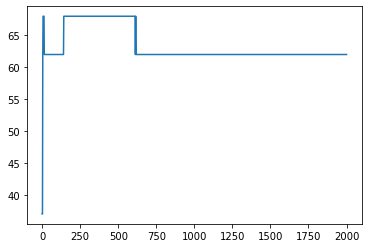

In [36]:
c_list = np.linspace(1e-2, 2e3, 1000)
acc_list = []
for c in c_list:
    logr_23 = LogisticRegression(C=c, max_iter=10000, class_weight=class_weight_23,
        multi_class='ovr').fit(eweight_train, elabel_train)
    label_test_pre = logr_23.predict(eweight_test)

    res_label = np.abs(elabel_test-label_test_pre)
    len_true = len(np.where(res_label==0)[0])
    acc = int(len_true/len(elabel_test)*100)
    acc_list.append(acc)

plt.plot(c_list, acc_list)

Save classifier 1&2+3 and 2&3

In [38]:
import pickle
date = '20221107'
pth_lr = '/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools/CE_MC/runs/demo/'
create_dir(pth_lr+date)
name_12 = '/blr_12.sav'
pickle.dump(logr_12, open(pth_lr+date+name_12, 'wb'))
name_23 = '/blr_23.sav'
pickle.dump(logr_23, open(pth_lr+date+name_23, 'wb'))

Created Directory :  /media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools/CE_MC/runs/demo/20221107


##### LR analysis for mapping CF to E

and save the LR param.

In [39]:
e_1 = energy_hist[ind_e1]
e_2 = energy_hist[ind_e2]
e_3 = energy_hist[ind_e3]

clf_1 = BayesianRidge().fit(weight_e1, e_1)
clf_2 = BayesianRidge().fit(weight_e2, e_2)
clf_3 = BayesianRidge().fit(weight_e3, e_3)

date = '20221107'
pth_lr = '/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools/CE_MC/runs/demo/'
create_dir(pth_lr+date)
name_1 = '/clf_1.sav'
pickle.dump(clf_1, open(pth_lr+date+name_1, 'wb'))
name_2 = '/clf_2.sav'
pickle.dump(clf_2, open(pth_lr+date+name_2, 'wb'))
name_3 = '/clf_3.sav'
pickle.dump(clf_3, open(pth_lr+date+name_3, 'wb'))

Directory already existed :  /media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools/CE_MC/runs/demo/20221107


Find the optimal set of clusters

In [112]:
msad_list.shape

(1000,)

In [141]:
res_list = []
for i in range(100):
    msad_train, msad_test, weight_train, weight_test = train_test_split(
        torch.from_numpy(msad_list).clone().reshape(-1,1), weight_list, test_size=0.05)
    
    #*Linear regression
    weight_train_, msad_train_ = weight_train.clone(), msad_train.clone()
    weight_test_, msad_test_ = weight_test.clone(), msad_test.clone()

    clf_ = BayesianRidge().fit(weight_train.detach().cpu().numpy(), msad_train.detach().cpu().numpy().flatten())
    msad_predict_lr = clf_.predict(weight_test.detach().cpu().numpy())

    res = msad_predict_lr-msad_test.numpy().flatten()
    res_list += (res.tolist())

np.linalg.norm(res_list)

36.18699289587543

Seperate the datasets.

In [7]:
msad_train, msad_test, weight_train, weight_test = train_test_split(
    torch.from_numpy(msad_list).clone().reshape(-1,1), weight_list, test_size=0.05)

In [ ]:
#*Linear regression
weight_train_, msad_train_ = weight_train.clone(), msad_train.clone()
weight_test_, msad_test_ = weight_test.clone(), msad_test.clone()

#* Bayesian Ridge LR
clf_ = BayesianRidge().fit(weight_train_.detach().cpu().numpy(), msad_train_.detach().cpu().numpy().flatten())
msad_predict_lr = clf_.predict(weight_test_.detach().cpu().numpy())

In [8]:
#*Linear regression
weight_train_, msad_train_ = weight_train.clone(), msad_train.clone()
weight_test_, msad_test_ = weight_test.clone(), msad_test.clone()

#* Gaussian Process regression
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel,
    random_state=0).fit(weight_train_.detach().cpu().numpy(), msad_train_.detach().cpu().numpy().flatten())
msad_predict_lr = gpr.predict(weight_test_.detach().cpu().numpy())

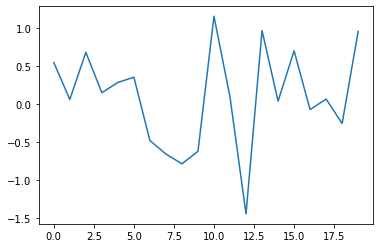

In [9]:
plt.plot(msad_predict_lr-msad_test.numpy().flatten())

In [11]:
import pickle
date = '20221119'
pth_lr = '/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools/CE_MC/runs/demo/'
create_dir(pth_lr+date)
name = '/gpr_msad.sav'
pickle.dump(gpr, open(pth_lr+date+name, 'wb'))

Directory already existed :  /media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools/CE_MC/runs/demo/20221119


In [12]:
weight_test.shape

torch.Size([20, 279])

To calculate the **TURE** MSAD in randomized states?

1. Generate configs without constraints.

2. Put those configs into CE prediction.

3. The outputs must follow a distribution that represents the latent dist. at 0 K.

Then take **ensemble average** of outputs to obtain $MSAD^{1/2}$.

6.360689253661201


(array([  1.,   0.,   0.,   0.,   0.,   0.,   2.,   1.,   4.,   6.,   7.,
          7.,  15.,  22.,  23.,  39.,  36.,  47.,  58.,  70.,  99., 112.,
        105., 139., 100., 117., 116., 120., 112., 102.,  93.,  86.,  56.,
         51.,  57.,  49.,  29.,  28.,  13.,  16.,  10.,  17.,   9.,   5.,
         11.,   6.,   1.,   1.,   0.,   2.]),
 array([3.54928007, 3.65675362, 3.76422716, 3.87170071, 3.97917425,
        4.0866478 , 4.19412134, 4.30159489, 4.40906843, 4.51654198,
        4.62401552, 4.73148907, 4.83896261, 4.94643616, 5.0539097 ,
        5.16138325, 5.26885679, 5.37633034, 5.48380388, 5.59127743,
        5.69875097, 5.80622452, 5.91369806, 6.02117161, 6.12864515,
        6.2361187 , 6.34359224, 6.45106579, 6.55853933, 6.66601288,
        6.77348642, 6.88095997, 6.98843351, 7.09590706, 7.2033806 ,
        7.31085415, 7.41832769, 7.52580124, 7.63327478, 7.74074833,
        7.84822187, 7.95569542, 8.06316896, 8.1706425 , 8.27811605,
        8.38558959, 8.49306314, 8.60053668, 8.

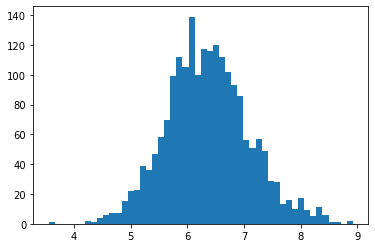

In [21]:
ele_list_predict, weight_list = [], []
for i in range(2000):
    ele_list = ele_list_gen(0.45, 0, 0.275, 0.275, 32)
    ele_list_predict.append(ele_list.tolist())
    weight_list.append(ce_.cluster_extra(np.tile(ele_list, 27)))

msad_list = gpr.predict(weight_list)
print(np.mean(msad_list))
plt.hist(msad_list, bins=50)

#### Fit the ECI based on **NN**

In [71]:
#* FC part
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

class fc(nn.Module):
    def __init__(self, state_dim):
        super(fc, self).__init__()

        self.state_dim = state_dim
        self.output = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(128, 1),
        )

    def forward(self, s_a):
        
        e_ = self.output(s_a)

        return e_

In [59]:
msad_test = msad_test.float()
msad_train = msad_train.float()
weight_test = weight_test.float()
weight_train = weight_train.float()

In [72]:
#* Training step
state_dim = 171
mini_batchsize = 16
lr_ = 1e-5
train_step = 3000000
epoch_per_episode = 16
path_save = '/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools/CE_MC/runs/demo'

#*Device is defined in former block
fc_ = fc(state_dim).to(device)
fc_optim = torch.optim.Adam(fc_.parameters(), lr = lr_)
scheduler = torch.optim.lr_scheduler.StepLR(fc_optim,step_size=10000,gamma = 0.98)
mse_loss = nn.MSELoss()
writer = SummaryWriter(log_dir = path_save)
torch.manual_seed(886)

for i in range(train_step):
    # for index in BatchSampler(SubsetRandomSampler(range(len(weight_train))), mini_batchsize, True):
        # for epoch in range(epoch_per_episode):
    fc_.train()
    weight_train_ = weight_train
    msad_train_ = msad_train
    msad_out_train = fc_(weight_train_)
    msad_tar_train = msad_train_
    msad_loss_train = mse_loss(msad_out_train, msad_tar_train)

    writer.add_scalar("Training Loss of MSAD", msad_loss_train, i)

    fc_optim.zero_grad()
    msad_loss_train.backward()
    clip_grad_norm_(fc_.parameters(), 1)
    fc_optim.step()
    scheduler.step()

    fc_.eval()
    msad_out_test = fc_(weight_test)
    msad_loss_test = mse_loss(msad_out_test, msad_test)
    writer.add_scalar("Testing Loss of MSAD", msad_loss_test, i)

KeyboardInterrupt: 

In [76]:
np.linalg.norm(nn_res)/len(nn_res)

0.14383346606523562

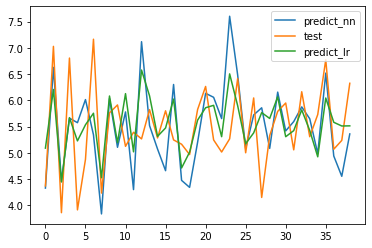

In [73]:
fc_.eval()
energy_std = 1
energy_mean = 0
e_predict = fc_(weight_test).cpu().detach().numpy()
e_test_ = msad_test.cpu().detach().numpy()
e_predict_lr_ = msad_predict_lr

plt.plot(e_predict, label='predict_nn')
plt.plot(e_test_, label='test')
plt.plot(e_predict_lr_, label='predict_lr')

plt.legend()
plt.show()

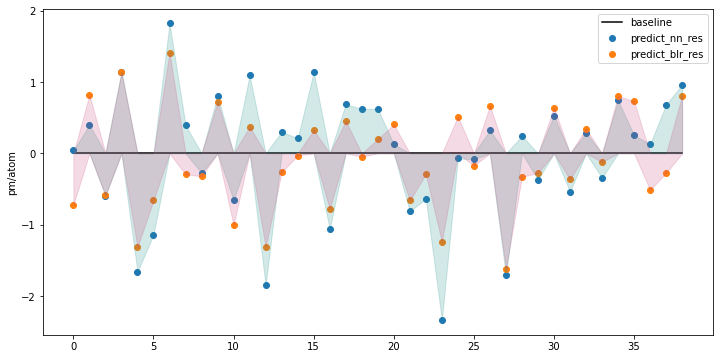

In [74]:
nn_res = (e_test_ - e_predict)
lr_res = (e_test_ - e_predict_lr_.reshape(-1,1))
r_nn_u = np.clip(nn_res, 0, None).flatten()
r_nn_l = np.clip(nn_res, None, 0).flatten()
r_lr_u = np.clip(lr_res, 0, None).flatten()
r_lr_l = np.clip(lr_res, None, 0).flatten()

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_ylabel('pm/atom')
x_axis = np.arange(len(e_test_))
plt.scatter(x_axis, nn_res, label='predict_nn_res')
plt.scatter(x_axis, lr_res, label='predict_blr_res')
plt.plot(x_axis, np.zeros(len(msad_test)), c='k', label='baseline', zorder=0)
plt.fill_between(x_axis, r_nn_l, r_nn_u, 
            alpha=0.2, color=cm.viridis(0.5))
plt.fill_between(x_axis, r_lr_l, r_lr_u, 
            alpha=0.2, color=cm.plasma(0.5))

plt.legend()
plt.show()

In [71]:
###
#* Save NN model
pth_save = '/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools/CE_MC/runs/demo/20221031'
torch.save(fc_.state_dict(), pth_save+'/param.pth')

#### SA processes:

1. Starting from **LOCAL MINIMA**

2. Start SA, temperature should gradually increases to ensure the stability of system.

##### Supplementary

1. $$<\alpha> = \frac{\sum\alpha e^{-\beta H_i}}{\sum e^{-\beta H_i}} \tag{1}$$

$$<\alpha>_t = 1/t \sum \alpha(t) \tag{2}$$

2. $T(t) = T_0e^{-t/\tau}$

Text(0.5, 1.0, 'Final temp.: 54.94691666620253 K')

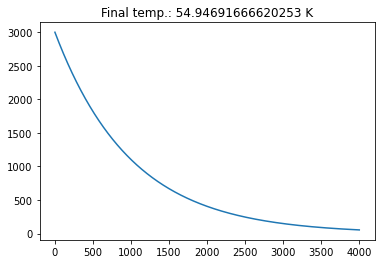

In [16]:
#* Test the setting of temperature decay.
def temp(temp_0, t, tau):
    return temp_0*np.exp(-t/tau)

t = np.linspace(0, 4000, 3001)
temp_ = temp(3000, t, 1000)

plt.plot(t, temp_)
plt.title(f'Final temp.: {temp_[-1]} K')

#### Analysis part for global minimum configuration.

In [14]:
#* Analysis from .py file
import pickle
e_list = np.load('/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools/CE_MC/runs/demo/20221101/min_e_.npy')
config_list = np.load('/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools/CE_MC/runs/demo/20221101/minconfig_.npy')
lr_model = '/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools/CE_MC/runs/demo/20221101/blr.sav'
lr_model_ = pickle.load(open(lr_model, 'rb'))

# lr_model_.predict(config_list)
e_list

array([-15860.06482684, -15861.29076902, -15852.86736414, -15848.19600287,
       -15853.7409672 , -15858.94716383, -15854.62429982, -15852.32496535,
       -15847.70857096, -15853.42011043, -15849.80098587, -15853.33225516])

##### Debugging console for SRO evaluation.

In [9]:
#* Estimation step
#* Use NN?
# fc_.eval()

def norm_w(x, x_mean, x_std):
        return (x - x_mean) / x_std

def t_range(temp_0, t, tau):
    return temp_0*np.exp(-t/tau)

ind_1nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_1nn.npy')
ind_2nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_2nn.npy')
ind_3nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_3nn.npy')
ind_4nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_4nn.npy')
ind_qua1nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_qua1nn.npy')
ind_qua1nn2nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_qua1nn2nn.npy')
ind_trip1nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_trip1nn.npy')
ind_trip1nn2nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_trip1nn2nn.npy')
ind_trip1nn2nn3nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_trip1nn2nn3nn.npy')

ind_1nn_pbc = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_1nn_pbc.npy')
ind_2nn_pbc = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_2nn_pbc.npy')
ind_3nn_pbc = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_3nn_pbc.npy')
ind_4nn_pbc = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_4nn_pbc.npy')
ind_qua1nn_pbc = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_qua1nn_pbc.npy')
# ind_qua1nn2nn_pbc = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_32/ind_qua1nn2nn_pbc.npy')
ind_trip1nn_pbc = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_trip1nn_pbc.npy')
ind_trip1nn2nn_pbc = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_trip1nn2nn_pbc.npy')
ind_trip1nn2nn3nn_pbc = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_trip1nn2nn3nn_pbc.npy')

ind_raw = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_raw2048.npy')

ce_e = CE(ind_1nn, ind_2nn, ind_3nn, ind_4nn, 
        ind_qua1nn, ind_trip1nn, ind_trip1nn2nn, ind_trip1nn2nn3nn,
        ind_1nn_pbc, ind_2nn_pbc, ind_3nn_pbc, ind_4nn_pbc, 
        ind_qua1nn_pbc, ind_trip1nn_pbc, ind_trip1nn2nn_pbc, ind_trip1nn2nn3nn_pbc,
        ind_raw)

pth_raw = '/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools/CE_MC/runs/demo/'

#* Load Classifier
blr_12 = pth_raw+'20221107/blr_12.sav'
blr_23 = pth_raw+'20221107/blr_23.sav'

blr_12 = pickle.load(open(blr_12, 'rb'))
blr_23 = pickle.load(open(blr_23, 'rb'))

#* Load ECI parameters
clf_1 = pth_raw+'20221107/clf_1.sav'
clf_2 = pth_raw+'20221107/clf_2.sav'
clf_3 = pth_raw+'20221107/clf_3.sav'

clf_1 = pickle.load(open(clf_1, 'rb'))
clf_2 = pickle.load(open(clf_2, 'rb'))
clf_3 = pickle.load(open(clf_3, 'rb'))

#* Load tensorboard
date = '20221113'
pth_tb = f'/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools/CE_MC/runs/demo/{date}'
writer = SummaryWriter(log_dir = pth_tb)

energy_std, energy_mean = 1, 0

config = ele_list_gen(1/4, 1/4, 1/4, 1/4, num_c=2048)
iter_time= 10000
temp = 1200
k_ = 8.617333262e-5
atom_num = 2048
# energy_std = 1
config_list = np.zeros((50, atom_num))
e_list_store = np.zeros(50)
sro_list_store = np.zeros((iter_time, 12))

for i in range(iter_time):
        # weight_config = norm_w(ce_e.cluster_extra(config).reshape(-1,1).T,
        #                 weight_mean, weight_std)
        config_tile = np.tile(config, 27) #* In 3*3*3 PBC space.
        weight_config  = ce_e.cluster_extra(config_tile).reshape(-1,1).T

        #* Prediction part
        label = int(blr_12.predict(weight_config)[0])
        if label == 0:
                energy = (clf_1.predict(weight_config)*energy_std + energy_mean)[0]
        else:
                label_ = int(blr_23.predict(weight_config)[0])
                if label_ == 0:
                        energy = (clf_2.predict(weight_config)*energy_std + energy_mean)[0]
                else:
                        energy = (clf_3.predict(weight_config)*energy_std + energy_mean)[0]  

        #* NN's prediction
        # weight_config = torch.from_numpy(weight_config.astype(np.float32)).clone().to(device)
        # energy = fc_(weight_config).cpu().detach().numpy()[0,0]*energy_std + energy_mean
        energy *= atom_num
        # e_list.append(energy)
        config_list[i%50] = config
        e_list_store[i%50] = energy
        #* Extract SRO params of current config..
        sro = sub_func_ce.sro_extra(ind_1nn, config, 0.25, 0.25, 0.25, 0.25)
        sro_list_store[i%iter_time] = sro
        
        writer.add_scalar(f'Thermo-MC Energy (eV)', energy, i)
        writer.add_scalar(f'SRO param/CrCr', sro[0], i)
        writer.add_scalar(f'SRO param/MnMn', sro[1], i)
        writer.add_scalar(f'SRO param/CoCo', sro[2], i)
        writer.add_scalar(f'SRO param/NiNi', sro[3], i)
        writer.add_scalar(f'SRO param/CrMn', sro[4], i)
        writer.add_scalar(f'SRO param/CrCo', sro[5], i)
        writer.add_scalar(f'SRO param/CrNi', sro[6], i)
        writer.add_scalar(f'SRO param/MnCo', sro[7], i)
        writer.add_scalar(f'SRO param/MnNi', sro[8], i)
        writer.add_scalar(f'SRO param/CoNi', sro[9], i)

        while True:
                a_ind = randrange(len(ind_1nn))
                action = ind_1nn[a_ind]
                a1, a2 = config[action[0]], config[action[1]]
                if a1 != a2:
                        break

        config_ = swap_step(action, config)

        assert np.linalg.norm(np.sort(config_)-np.sort(config)) == 0, print(f'BUG in swap_step')
        # weight_config_ = norm_w(ce_e.cluster_extra(config_).reshape(-1,1).T,
        #                 weight_mean, weight_std)
        config_tile_ = np.tile(config_, 27) #* In 3*3*3 PBC space.
        weight_config_ = ce_e.cluster_extra(config_tile_).reshape(-1,1).T
        #* NN's prediction
        # weight_config_ = torch.from_numpy(weight_config_.astype(np.float32)).clone().to(device)
        # energy_ = fc_(weight_config_).cpu().detach().numpy()[0,0]*energy_std + energy_mean
        #* Prediction part
        label = int(blr_12.predict(weight_config_)[0])
        if label == 0:
                energy_ = (clf_1.predict(weight_config_)*energy_std + energy_mean)[0]
        else:
                label_ = int(blr_23.predict(weight_config_)[0])
                if label_ == 0:
                        energy_ = (clf_2.predict(weight_config_)*energy_std + energy_mean)[0]
                else:
                        energy_ = (clf_3.predict(weight_config_)*energy_std + energy_mean)[0] 

        energy_ *= atom_num

        accept = np.min([1, np.exp((energy-energy_)/(k_*temp))])
        r_v = np.random.rand()
        if r_v <= accept:
                config = config_
        else:
                config = config

        clear_output(True)
        # plt.title(f'Iter num {i} at {temp} K')
        # plt.plot(e_list)
        # plt.show()

In [2]:
config = ele_list_gen(1/4, 1/4, 1/4, 1/4, num_c=2048)
ind_1nn = np.load('/media/wz/7AD631A4D6316195/Projects/mc_pure_qua/fcc_2048/ind_1nn.npy')
sub_func_ce.sro_extra(ind_1nn, config, 0.25, 0.25, 0.25, 0.25)

array([ 5.01481481e-01,  5.02962963e-01,  4.88148148e-01,  5.00000000e-01,
        1.40740741e-02, -1.40740741e-02,  2.22222222e-03, -7.40740741e-04,
        4.44444444e-03,  1.48148148e-03,  1.08000000e+04,  1.08000000e+04])

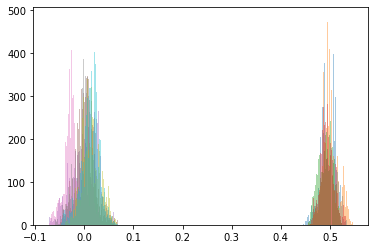

In [11]:
%matplotlib inline
from fitter import Fitter
#* Check the distribution of energy
for i in range(sro_list_store.shape[1]-2):
    sro = sro_list_store[:,i]
    plt.hist(sro, bins=100, alpha=0.4)

plt.show()
# f_pair = Fitter(mncr_list, distributions = ['norm'], timeout = 1500)
# f_pair.fit()

# print(f_pair.get_best())
# f_pair.summary()

In [10]:
np.save('/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools/CE_MC/runs/demo/20221107/sro_1200.npy', sro_list_store)

In [12]:
# sro_100 = np.load('/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools/CE_MC/runs/demo/20221107/sro_100.npy')
sro_400 = np.load('/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools/CE_MC/runs/demo/20221107/sro_400.npy')
sro_1200 = np.load('/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools/CE_MC/runs/demo/20221107/sro_1200.npy')
# sro_4000 = np.load('/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools/CE_MC/runs/demo/20221107/sro_4000.npy')

# sro_100_mean = np.mean(sro_100[1000:], 0).reshape(-1,1)
sro_400_mean = np.mean(sro_400[1000:], 0).reshape(-1,1)
sro_1200_mean = np.mean(sro_1200[1000:], 0).reshape(-1,1)
# sro_4000_mean = np.mean(sro_4000[1000:], 0).reshape(-1,1)

sro_mean = np.concatenate([sro_400_mean, sro_1200_mean], 1)

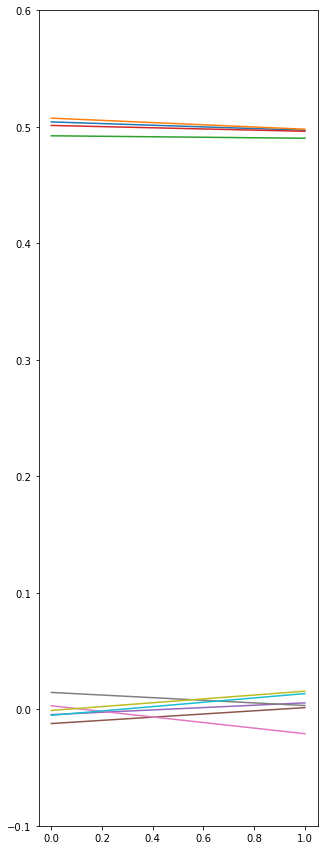

In [18]:
fig, ax = plt.subplots(figsize=(5, 15))

for i in range(len(sro_400_mean)-2):
    plt.plot(sro_mean[i])

plt.ylim([-0.1, 0.6])
plt.show()

#### Analyzing CE estimations

Results are following an order of 

a_crcr, a_mnmn, a_coco, a_nini, a_mncr, a_cocr, a_nicr, a_comn, a_nimn, a_nico

In [18]:
sro_name = ['a_crcr', 'a_mnmn', 'a_coco', 'a_nini', 'a_mncr', 'a_cocr', 'a_nicr', 'a_comn', 'a_nimn', 'a_nico']
temp_range = np.array([100, 200, 300, 400, 500, 800, 1000, 1200, 1600, 2400, 3200, 4800])
sro_list = np.zeros((len(temp_range), 10)) #* Nx10
pth_raw = '/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools/CE_MC/runs/demo/20221101/'
for i in range(len(temp_range)):
    sro_list[i] = np.mean(np.load(pth_raw+f'sro_{temp_range[i]}.npy'), axis=0)

sro_list.shape

(12, 10)

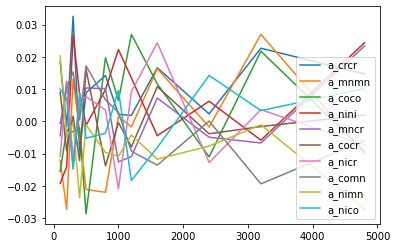

In [20]:
for i in range(10):
    plt.plot(temp_range, sro_list[:, i], label=sro_name[i])

plt.legend()
plt.show()